In [1]:
import yfinance as yf

In [2]:
pip install --upgrade yfinance

In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# 1. Confirm yfinance version (should be ≥ 0.2.54)
print("yfinance version:", yf.__version__)  # ✓

# 2. Define tickers and date range
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = end - timedelta(days=365)

try:
    # 3. Download data with valid parameters
    df_all = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        threads=False,        # avoids multi-threading issues
        timeout=60,           # seconds per request
        group_by='ticker',    # columns grouped by ticker
        ignore_tz=True,       # avoids timezone errors
        progress=False        # clean terminal output
    )

    # 4. Flatten multi-index columns into a tidy DataFrame
    df_flat = (
        df_all
        .stack(level=0)                     # ticker becomes row index
        .rename_axis(['Date', 'Ticker'])   # rename index levels
        .reset_index()                      # convert to columns
    )

    print(df_flat.head(5))
except Exception as e:
    print("Download error:", e)


yfinance version: 0.2.62


<ipython-input-3-705ef389e4d7>:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_all = yf.download(


Price       Date Ticker        Open        High         Low       Close  \
0     2024-06-10   AAPL  195.983442  196.381589  191.255553  192.221039   
1     2024-06-10   AMZN  184.070007  187.229996  183.789993  187.059998   
2     2024-06-10   GOOG  175.818028  177.830797  173.755449  175.997391   
3     2024-06-10   MSFT  421.468668  424.822926  420.664834  424.614532   
4     2024-06-11   AAPL  192.748571  206.195693  192.728675  206.185730   

Price     Volume  
0       97262100  
1       34494500  
2       17122200  
3       14003000  
4      172373300  


<ipython-input-3-705ef389e4d7>:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)                     # ticker becomes row index


In [4]:
df_all['GOOG'].describe()

Price,Open,High,Low,Close,Volume
count,249.000000,249.000000,249.000000,249.000000,2.490000e+02
mean,173.501235,175.539483,171.545590,173.446933,2.039249e+07
std,13.067252,13.112124,13.236174,13.220125,9.428203e+06
min,143.389999,151.059998,142.660004,146.580002,6.809800e+06
25%,164.405968,166.352055,162.964247,164.146561,1.413950e+07
50%,170.279999,171.940002,168.524994,170.232712,1.763230e+07
75%,183.590841,185.084718,182.075548,182.942444,2.377260e+07
max,204.267279,208.462496,204.027547,207.473633,7.872980e+07


In [5]:
df_all['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-06-10 to 2025-06-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    249 non-null    float64
 1   High    249 non-null    float64
 2   Low     249 non-null    float64
 3   Close   249 non-null    float64
 4   Volume  249 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.7 KB


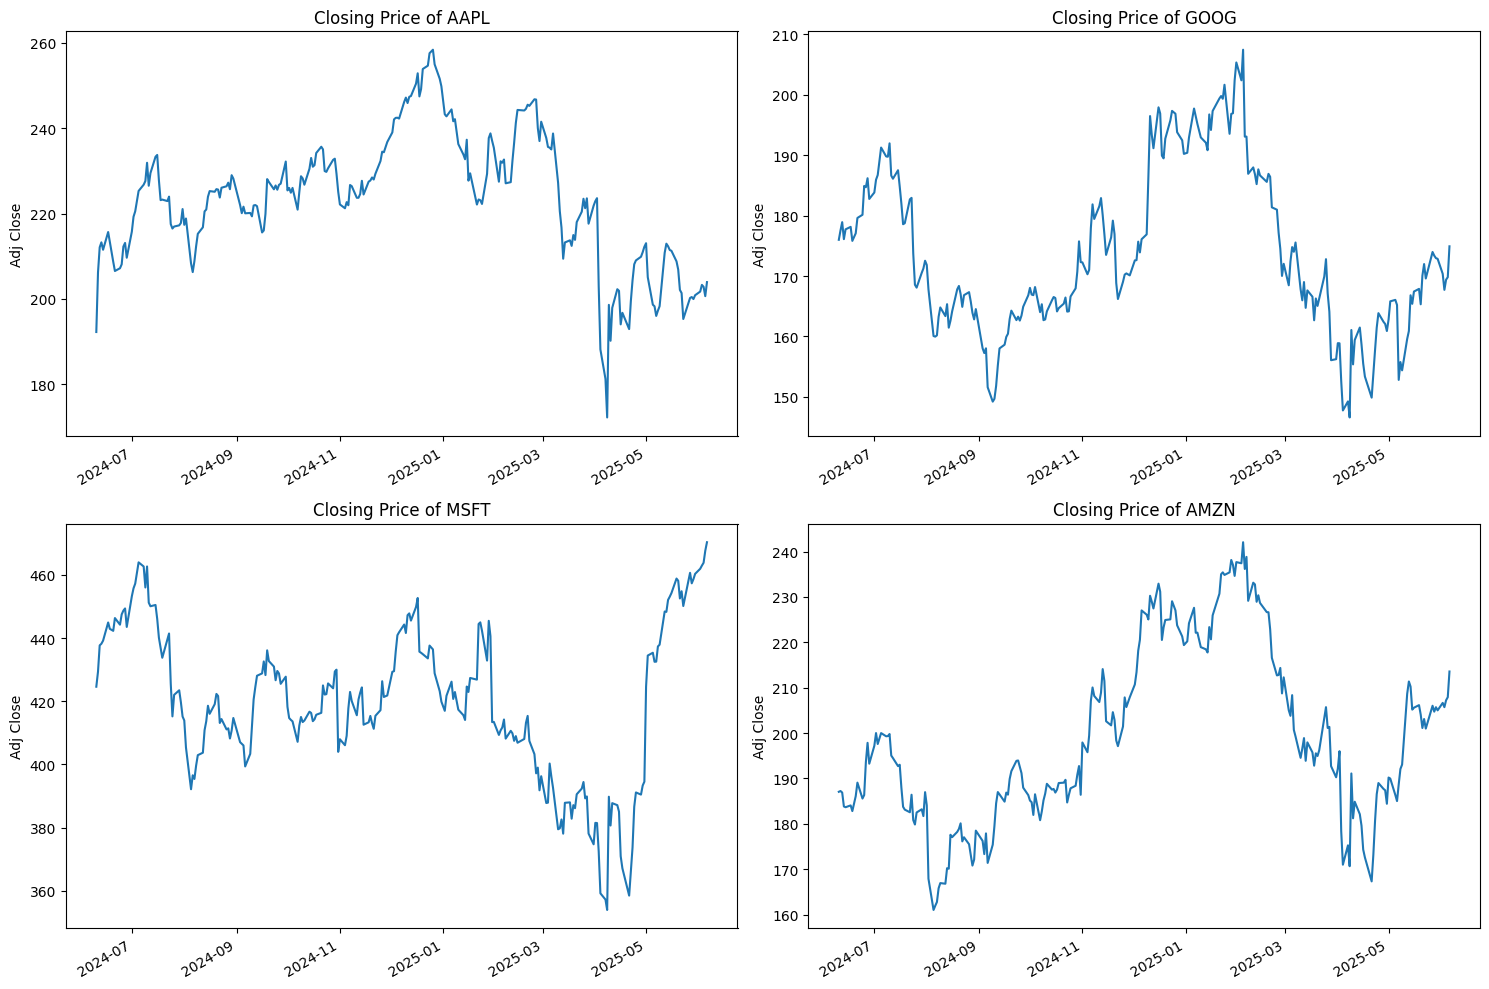

In [6]:
import matplotlib.pyplot as plt

# Assuming df_all is already defined and contains the downloaded stock data

# Create a figure with subplots
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Loop through each ticker and plot the adjusted closing price
for i, company in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    df_all[company]['Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


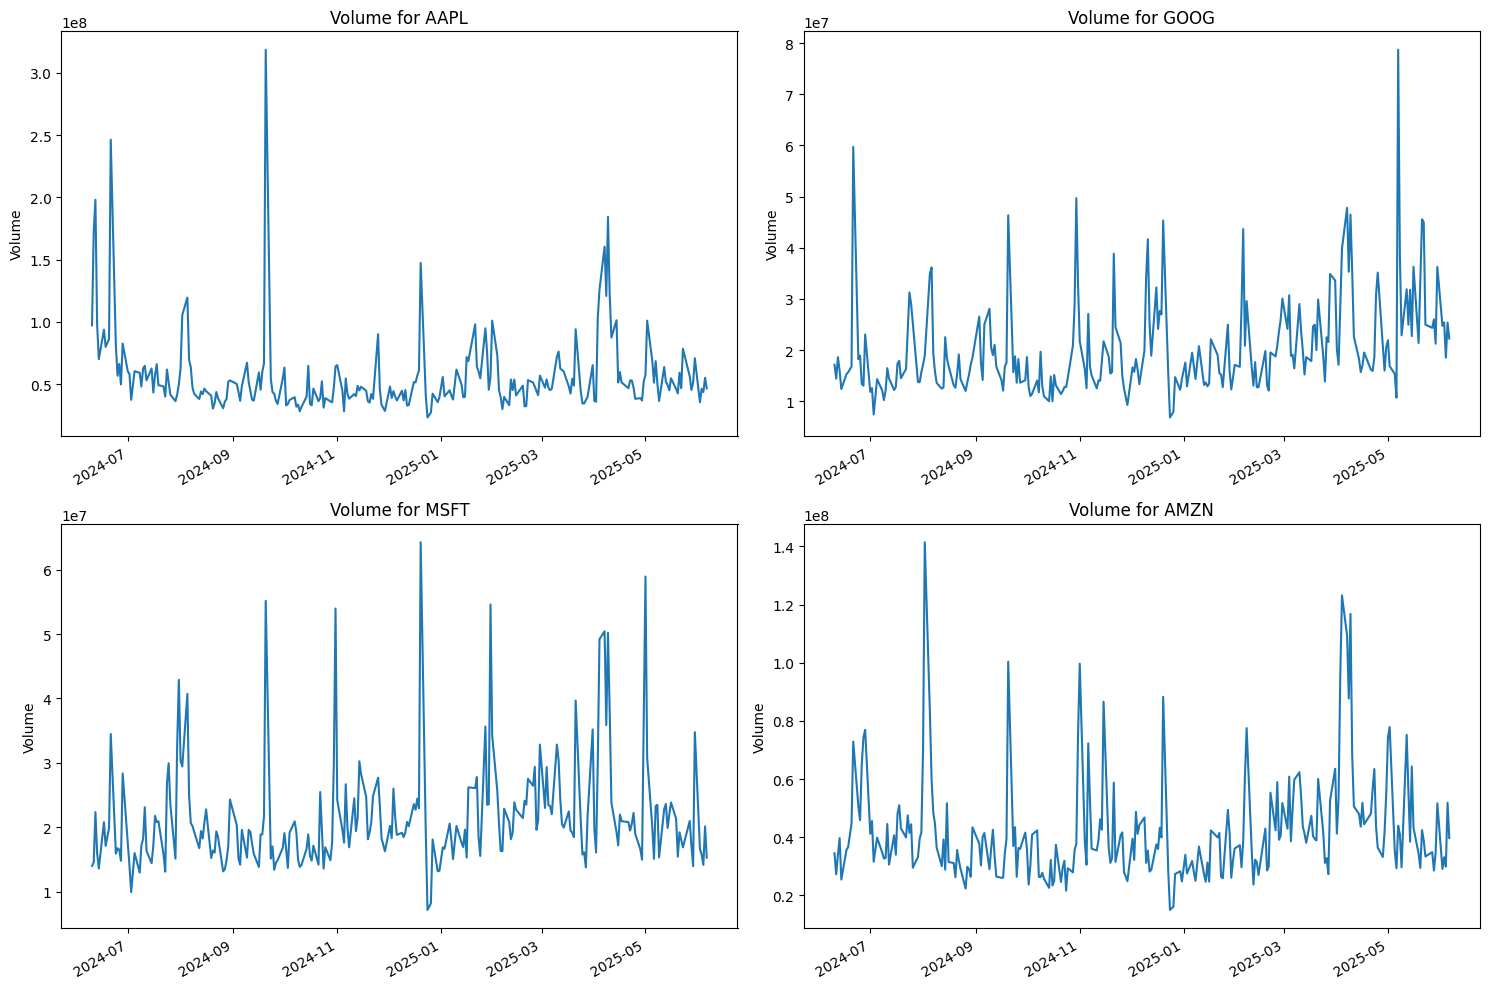

In [7]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    df_all[company]['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Volume for {company}")

plt.tight_layout()

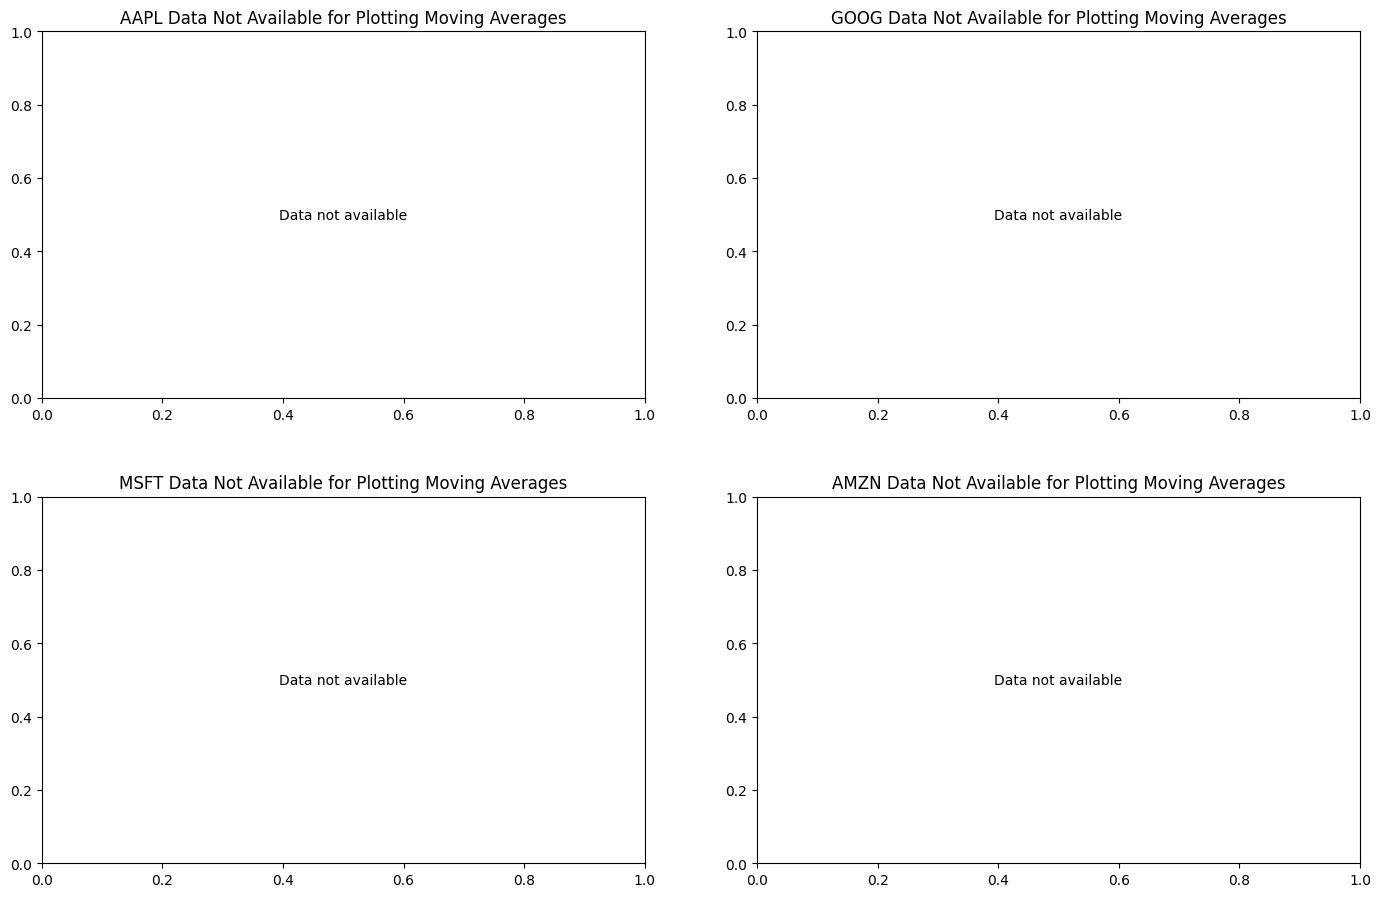

In [8]:
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported

# Define the moving average windows
ma_days = [10, 20, 50]

# Calculate moving averages for each company
for company in tickers:
    # Check if the 'Adj Close' column exists for the current company
    if ('Adj Close' in df_all[company].columns):
        for ma in ma_days:
            column_name = f"MA for {ma} days"
            df_all[company][column_name] = df_all[company]['Adj Close'].rolling(ma).mean()
    else:
        print(f"Warning: 'Adj Close' column not found for {company}. Skipping moving average calculation.")


# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# Plot data for each company
for i, company in enumerate(tickers):
    ax = axes[i // 2, i % 2]
    # Only attempt to plot 'Adj Close' and MAs if 'Adj Close' was available
    if ('Adj Close' in df_all[company].columns):
        # Construct the list of columns to plot, ensuring MAs are added only if calculated
        cols_to_plot = ['Adj Close']
        for ma in ma_days:
            ma_col_name = f"MA for {ma} days"
            if ma_col_name in df_all[company].columns:
                cols_to_plot.append(ma_col_name)

        df_all[company][cols_to_plot].plot(ax=ax)
        ax.set_title(f"{company} Stock Price and Moving Averages")
        ax.set_ylabel('Price (USD)')
        ax.set_xlabel('Date')
    else:
        ax.set_title(f"{company} Data Not Available for Plotting Moving Averages")
        ax.text(0.5, 0.5, "Data not available", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()

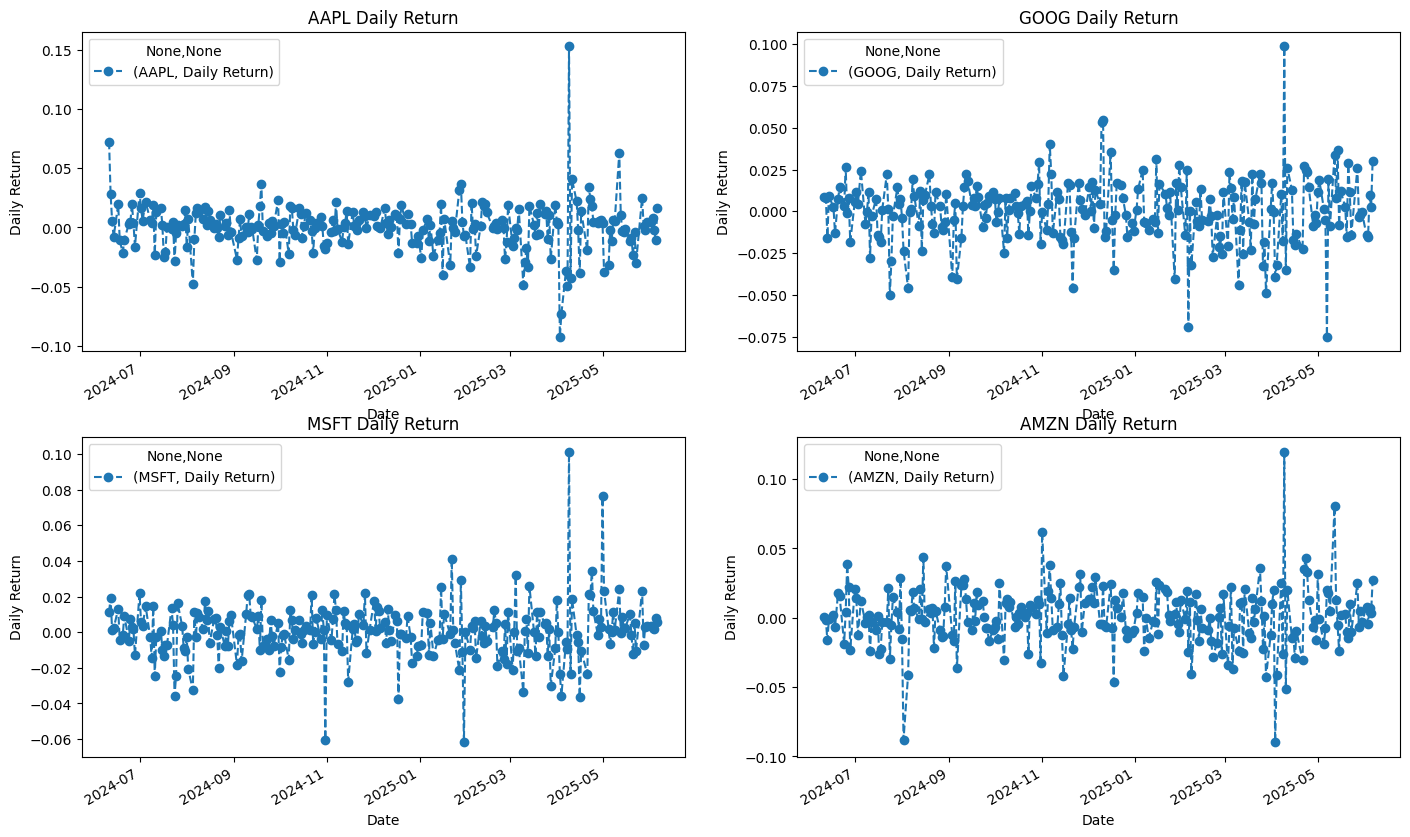

In [9]:
import matplotlib.pyplot as plt

# 1. Compute Daily Returns directly into df_all using .loc
for ticker in tickers:
    df_all.loc[:, (ticker, 'Daily Return')] = df_all[ticker]['Close'].pct_change()

# 2. Set up a 2×2 plot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# 3. Plot the daily returns for each ticker
for idx, ticker in enumerate(tickers):
    ax = axes[idx // 2, idx % 2]
    df_all[(ticker, 'Daily Return')].plot(
        ax=ax,
        legend=True,
        linestyle='--',
        marker='o'
    )
    ax.set_title(f"{ticker} Daily Return")
    ax.set_ylabel('Daily Return')
    ax.set_xlabel('Date')

plt.show()


In [10]:
end = datetime.now()
start = end - timedelta(days=365)
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

closing_df = yf.download(
    tickers=tickers,
    start=start,
    end=end,
    threads=False,
    timeout=60,
    progress=False,
    auto_adjust=False  # get Adj Close explicitly
)['Adj Close']

tech_rets = closing_df.pct_change()
print(tech_rets.head())

Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2024-06-10       NaN       NaN       NaN       NaN
2024-06-11  0.072649  0.000909  0.008832  0.011242
2024-06-12  0.028578 -0.001816  0.007688  0.019368
2024-06-13  0.005491 -0.016373 -0.015705  0.001179
2024-06-14 -0.008168 -0.000925  0.009223  0.002242


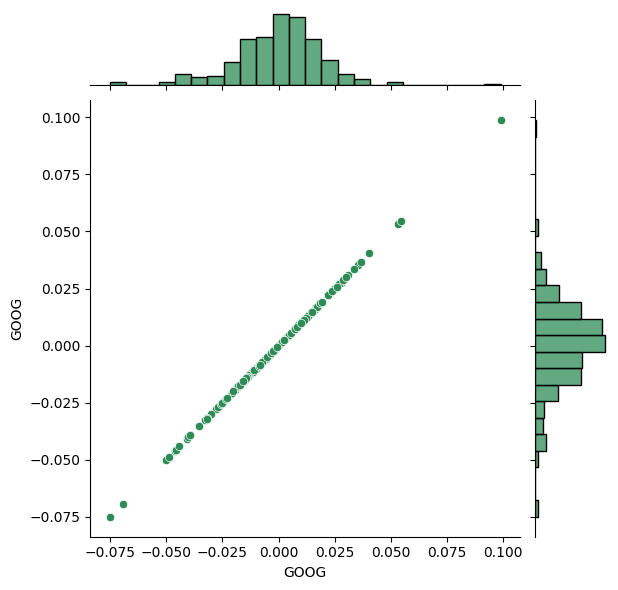

In [12]:
import seaborn as sns
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

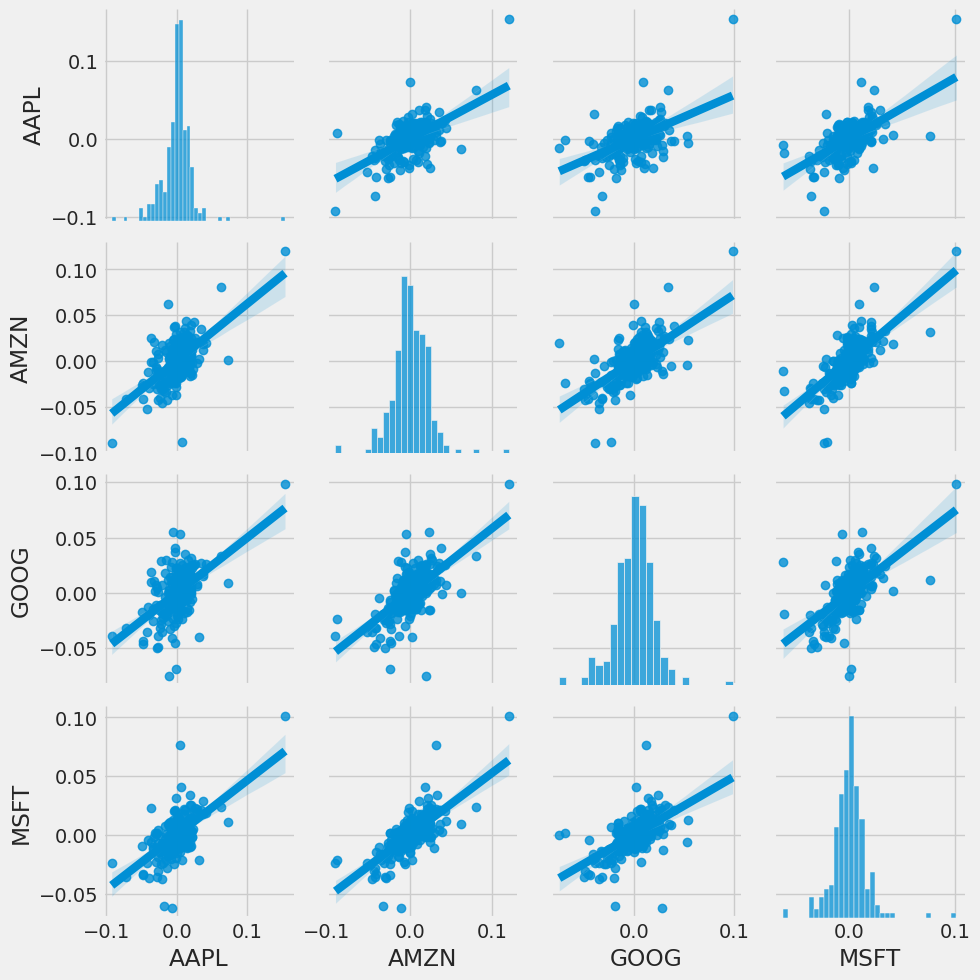

In [ ]:
sns.pairplot(tech_rets, kind='reg')

Text(0.5, 1.0, 'Correlation of stock closing price')

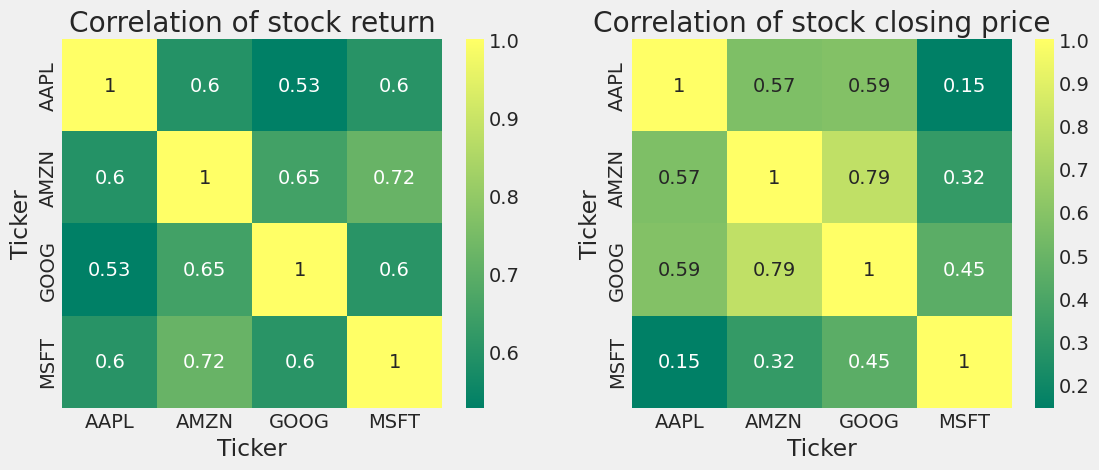

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

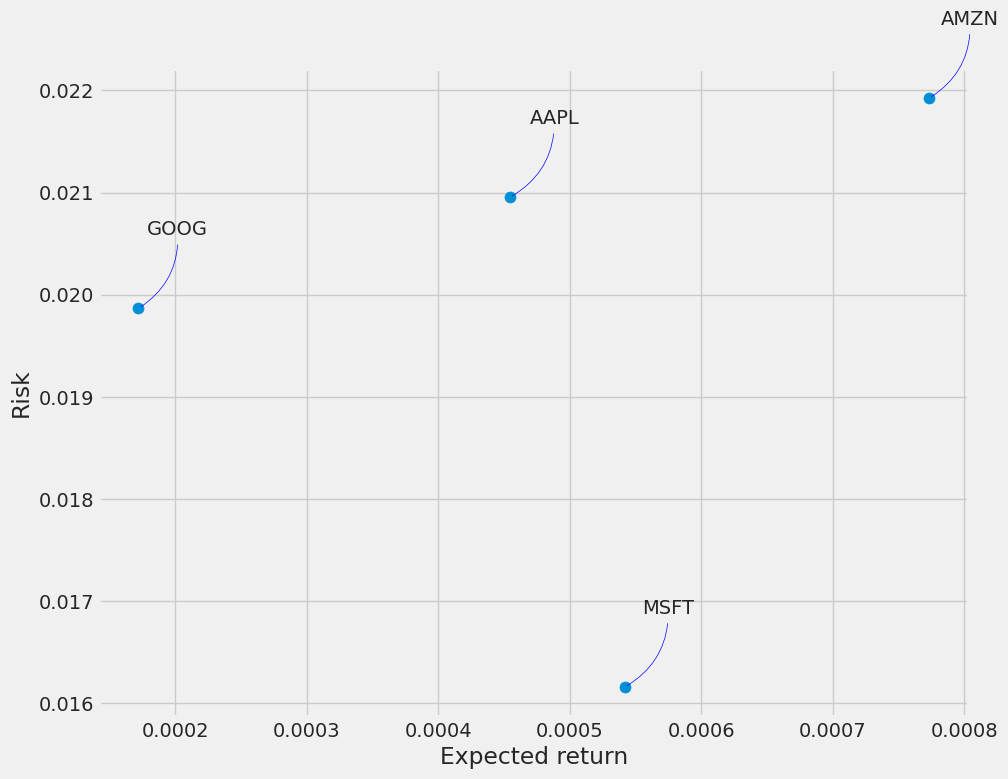

In [ ]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [13]:
df = yf.download(
    'AAPL',
    start='2012-01-01',
    end=datetime.now(),
    threads=False,
    timeout=60,
    progress=False
)
print(df.head())

<ipython-input-13-2be81da5ab10>:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.359182  12.397352  12.292162  12.304184  302220800
2012-01-04  12.425606  12.462874  12.300581  12.322219  260022000
2012-01-05  12.563552  12.579180  12.402461  12.470985  271269600
2012-01-06  12.694887  12.705406  12.599315  12.615845  318292800
2012-01-09  12.674751  12.855678  12.663330  12.788056  394024400


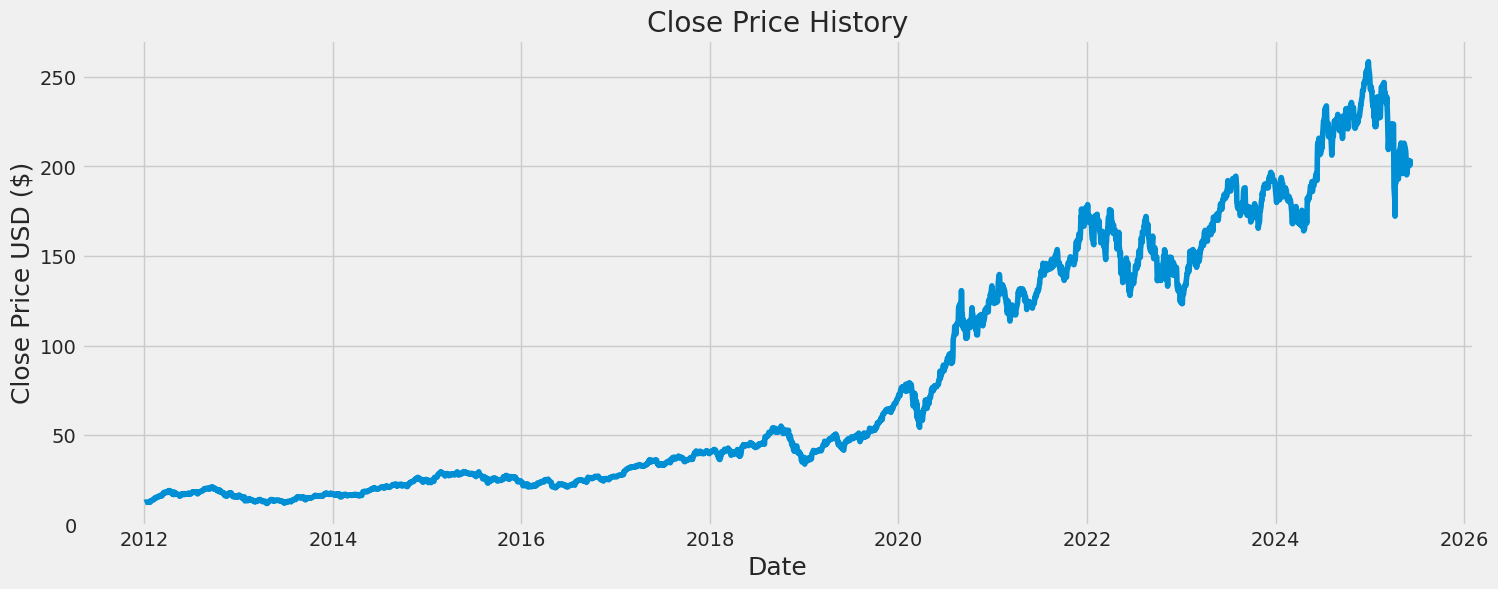

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [14]:
# 0. Inspect df
print("Columns:", df.columns)
print("Shape:", df.shape)
print(df.head())

# 1. Filter for 'Close' and validate it exists
if 'Close' not in df.columns:
    raise KeyError("Column 'Close' not found in df! Check your DataFrame.")

data = df[['Close']]
print("Filtered shape:", data.shape)

# 2. Convert to NumPy array
dataset = data.values
print("Dataset shape:", dataset.shape)  # Expect (n_rows, 1)

# 3. Scale only if valid
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

if dataset.ndim != 2 or dataset.shape[1] < 1:
    raise ValueError(f"Cannot scale dataset with shape {dataset.shape}")

scaled_data = scaler.fit_transform(dataset)
print("Scaled sample:\n", scaled_data[:5])


Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Shape: (3377, 5)
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.359182  12.397352  12.292162  12.304184  302220800
2012-01-04  12.425606  12.462874  12.300581  12.322219  260022000
2012-01-05  12.563552  12.579180  12.402461  12.470985  271269600
2012-01-06  12.694887  12.705406  12.599315  12.615845  318292800
2012-01-09  12.674751  12.855678  12.663330  12.788056  394024400
Filtered shape: (3377, 1)
Dataset shape: (3377, 1)
Scaled sample:
 [[0.0018211 ]
 [0.00209059]
 [0.00265024]
 [0.00318307]
 [0.00310137]]


In [22]:
import pickle

# Save the scaler object as 'scaler.pkl'
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl


In [23]:
from google.colab import files
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import numpy as np

# Create the training data set
# Create the scaled training data set

# Define the percentage of data to use for training
training_data_percentage = 0.8 # 80% of the data for training

# Calculate the length of the training data
training_data_len = int(np.ceil( len(scaled_data) * training_data_percentage ))

train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.0018211 , 0.00209059, 0.00265024, 0.00318307, 0.00310137,
       0.0032855 , 0.00320136, 0.00305992, 0.00286728, 0.00346351,
       0.00400123, 0.0038354 , 0.00292703, 0.00379394, 0.00294044,
       0.0061411 , 0.00589358, 0.0062167 , 0.00691535, 0.00733846,
       0.0073031 , 0.00717263, 0.00772866, 0.00825172, 0.00884432,
       0.00980147, 0.0118121 , 0.01184256, 0.01296189, 0.01379833,
       0.01236078, 0.01291434, 0.01290335, 0.01445553, 0.01423484,
       0.01464329, 0.01537734, 0.01578582, 0.01696243, 0.01781959,
       0.01806711, 0.01815369, 0.01668808, 0.0163345 , 0.01638693,
       0.01776474, 0.01815248, 0.01898522, 0.02094835, 0.02356742,
       0.02307724, 0.02307842, 0.02497205, 0.02556466, 0.02514275,
       0.02475746, 0.02435629, 0.02568899, 0.02660347, 0.02698631])]
[np.float64(0.026040138623708915)]

[array([0.0018211 , 0.00209059, 0.00265024, 0.00318307, 0.00310137,
       0.0032855 , 0.00320136, 0.00305992, 0.00286728, 0.00346351,
       0.00400123, 0.0

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import History
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model with accuracy as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(x_train, y_train, batch_size=1, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 9.9753e-04 - mae: 0.0197
Epoch 2/5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 3.1065e-04 - mae: 0.0120
Epoch 3/5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.7595e-04 - mae: 0.0090
Epoch 4/5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.7606e-04 - mae: 0.0087
Epoch 5/5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.6060e-04 - mae: 0.0081


In [19]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


np.float64(4.910754464215429)

<ipython-input-20-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


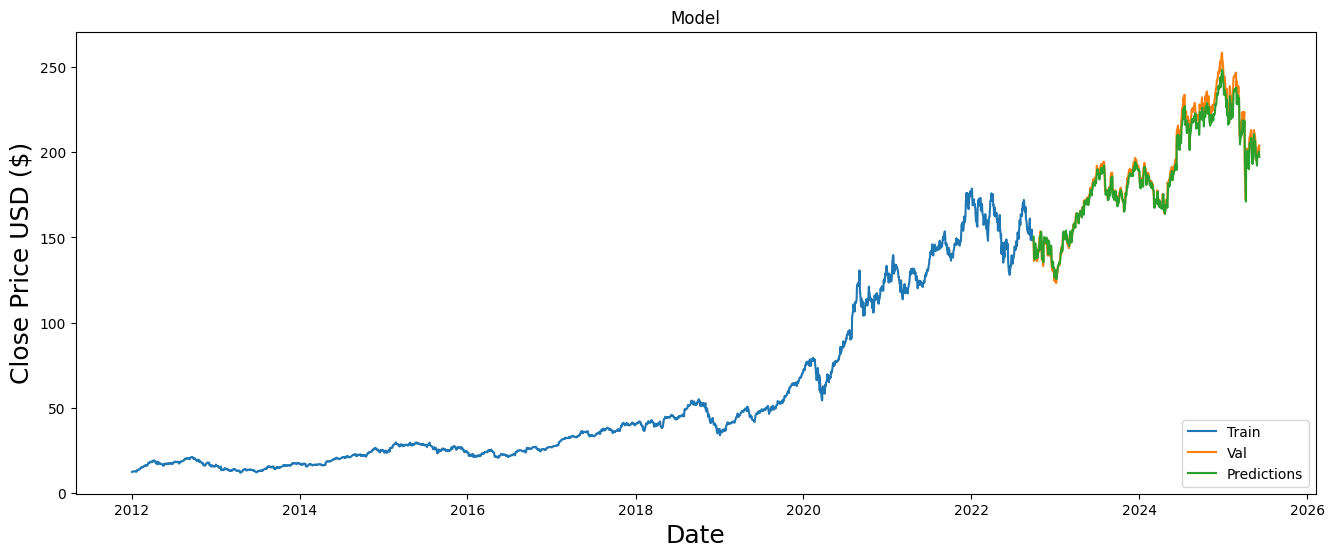

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

Price,Close,Predictions
Ticker,AAPL,
Date,,
2024-10-04,226.005554,218.802017
2024-10-07,220.913467,220.189026
2024-10-08,224.979187,214.781128
2024-10-09,228.735947,219.760132
2024-10-10,228.237701,222.684692
...,...,...
2025-06-02,201.699997,196.421967
2025-06-03,203.270004,197.137070


In [ ]:
# Save the entire model in HDF5 format
model.save('/content/my_model.h5')
